<a href="https://colab.research.google.com/github/mauro3/EGU2025-Julia-intro-and-showcase-for-geoscience/blob/ss%2Fnotebook-on-colab/global_ocean_simulation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Realistic Ocean Simulations in pure Julia

In this tutorial we will build a cupled global ocean-sea ice simulation using the ClimaOcean and Oceananigans Julia packages.
We will set up the grid, download and interpolate the bathymetry, download forcing files, and finally set up and run the simulation

## ClimaOcean.jl and Oceananigans.jl

ClimaOcean and Oceananigans are julia packages developed by the Climate Modeling Alliance (https://clima.caltech.edu/) that is building a complete earth system model in pure julia.

ClimaOcean is the de-facto CliMA ocean model used for realistic ocean-only and ocean and sea-ice simulations, in a region of the ocean ("regional") or covering the whole Earth.

Oceananigans, on the other hand, is the engine behind ClimaOcean. It contains all the ingredients for discretizing equations of motion on a discrete domain including spatial and temporal discretization, physical parameterizations, and utilities to run and analyze a fluid dynamic simulation. 

## Required software

The notebook is rather computationally expensive, therefore, it is recommended to run on GPUs. If you want to feel the raw power of GPUs, you can use google colab (https://colab.research.google.com/) that provides limited free access to NVIDIA T4 GPUs. Otherwise, if you have a GPU on your laptop, try it out!

However, for the purpose of understanding how the libraries work, a 2-degree global ocean model runs (slowly) on a laptop. 

## Packages:

Let's start by importing the necessary packages, these are:
- ClimaOcean: the ocean model
- Oceananigans: the fluid dynamics library doing the heavy lifting
- Printf: always useful for spitting out output
- CairoMakie: visualization package to visualize the results

In [1]:
using Pkg
Pkg.activate("./")
# pkg"add JLD2, ClimaOcean, Oceananigans#main, CairoMakie"

Pkg.update()

using ClimaOcean
using Oceananigans
using Oceananigans.Units
using Oceananigans.Grids
using Dates
using Printf
using CairoMakie

  Activating project at `~/EGU2025-Julia-intro-and-showcase-for-geoscience/global-ocean-notebooks`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/CliMA/Oceananigans.jl.git`
  No Changes to `~/EGU2025-Julia-intro-and-showcase-for-geoscience/global-ocean-notebooks/Project.toml`
  No Changes to `~/EGU2025-Julia-intro-and-showcase-for-geoscience/global-ocean-notebooks/Manifest.toml`
        Info We haven't cleaned this depot up for a bit, running Pkg.gc()...
┌ Error: GC failed
│   exception =
│    TOML Parser error:
│    /orcd/home/001/ssilvest/.julia/logs/scratch_usage.toml:6095:3 error: invalid bare key character: '\"'
│      ml"]
│        ^  
└ @ Pkg ~/.julia/juliaup/julia-1.10.9+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/Pkg.jl:799
┌ Warning: CUDA runtime library `libcublasLt.so.12` was loaded from a system path, `/orcd/software/community/001/rocky8/nvhpc/2024_245/Linux_x86_64/24.5/math_libs/lib64/libcublasLt.so.12`.
│ This m

# Building a Global Ocean domain

We will start building a global ocean in steps:
- (1) specifying an **Architecture**
- (2) choosing a **Vertical coordinate**
- (2) Building a **Grid**
- (3) Downloading an interpolating a **Bathymetry**

### Architectures

using an architecture is easy...
it is possible to choose between:
- (1) CPU
- (2) GPU
- (3) Distributed

If you have access to a GPU (either on the laptop, through ssh access, or through google colab) fire away! Otherwise, you probably need to set `arch = CPU()`

In [2]:
arch = CPU()

CPU()

## Building a grid

ClimaOcean allows building ocean simulations on three different grid types:
- `RectilinearGrid`s which represent a _box_ or a Cartesian domain
- `LatitudeLongitudeGrid`s, which discretizes the sphere along latitude and longitude lines
- `OrthogonalSphericalShellGrid`s which discretize the sphere with two-dimensional coordinates that do not need to follow latitude and longitude lines.
   The only constraint is that the grid must be locally orthogonal in the horizontal direction.

`LatitudeLongitudeGrid`s are the easiest grids to work with since coordinates are one-dimensional and globally orthogonal.
(i.e. latitude depends only on the `j`-index and longitude depends only on the `i`-index)
However, `LatitudeLongitudeGrid`s have the problem of the zonal spacing approaching zero as we move to the poles.

For this reason, to represent a global ocean we use a specific type of `OrthogonalSphericalShellGrid`,
called `TripolarGrid` that discretizes the sphere as a set of perpendicular ellipses and hyperbolae.
We pass to the grid, the architecture, the floating point precision, the size of the grid, and the vertical coordinate.
To enable $z^\star$ vertical coordinates, we wrap the r_faces (reference faces) around a `MutableVerticalDiscretization` type. The $z^\star$ coordinates will be chosed by default when constructing the model.

In [5]:
# Problem size
Nx = 256
Ny = 128
Nz = 15

# Vertical coordinate
depth   = 6000meters
r_faces = ClimaOcean.exponential_z_faces(; Nz, depth)
z_faces = MutableVerticalDiscretization(r_faces)

# Underlying grid
underlying_grid = TripolarGrid(arch; size=(Nx, Ny, Nz), z=z_faces, halo=(5, 5, 4))

# cpu grid
cpu_grid = Oceananigans.on_architecture(CPU(), underlying_grid)

256×128×15 OrthogonalSphericalShellGrid{Float64, Periodic, RightConnected, Bounded} on CPU with 5×5×4 halo and with precomputed metrics
├── centered at (λ, φ) = (70.0, 1.8005)
├── longitude: Periodic  extent 360.153 degrees       variably spaced with min(Δλ)=0.014941, max(Δλ)=1.48183
├── latitude:  RightConnected  extent 171.328 degrees variably spaced with min(Δφ)=0.022547, max(Δφ)=1.33858
└── z:         Bounded  z ∈ [-6000.0, 0.0]            variably spaced with min(Δr)=23.5814, max(Δr)=1572.56 (mutable)

#### Let's visualize the grid using CairoMakie

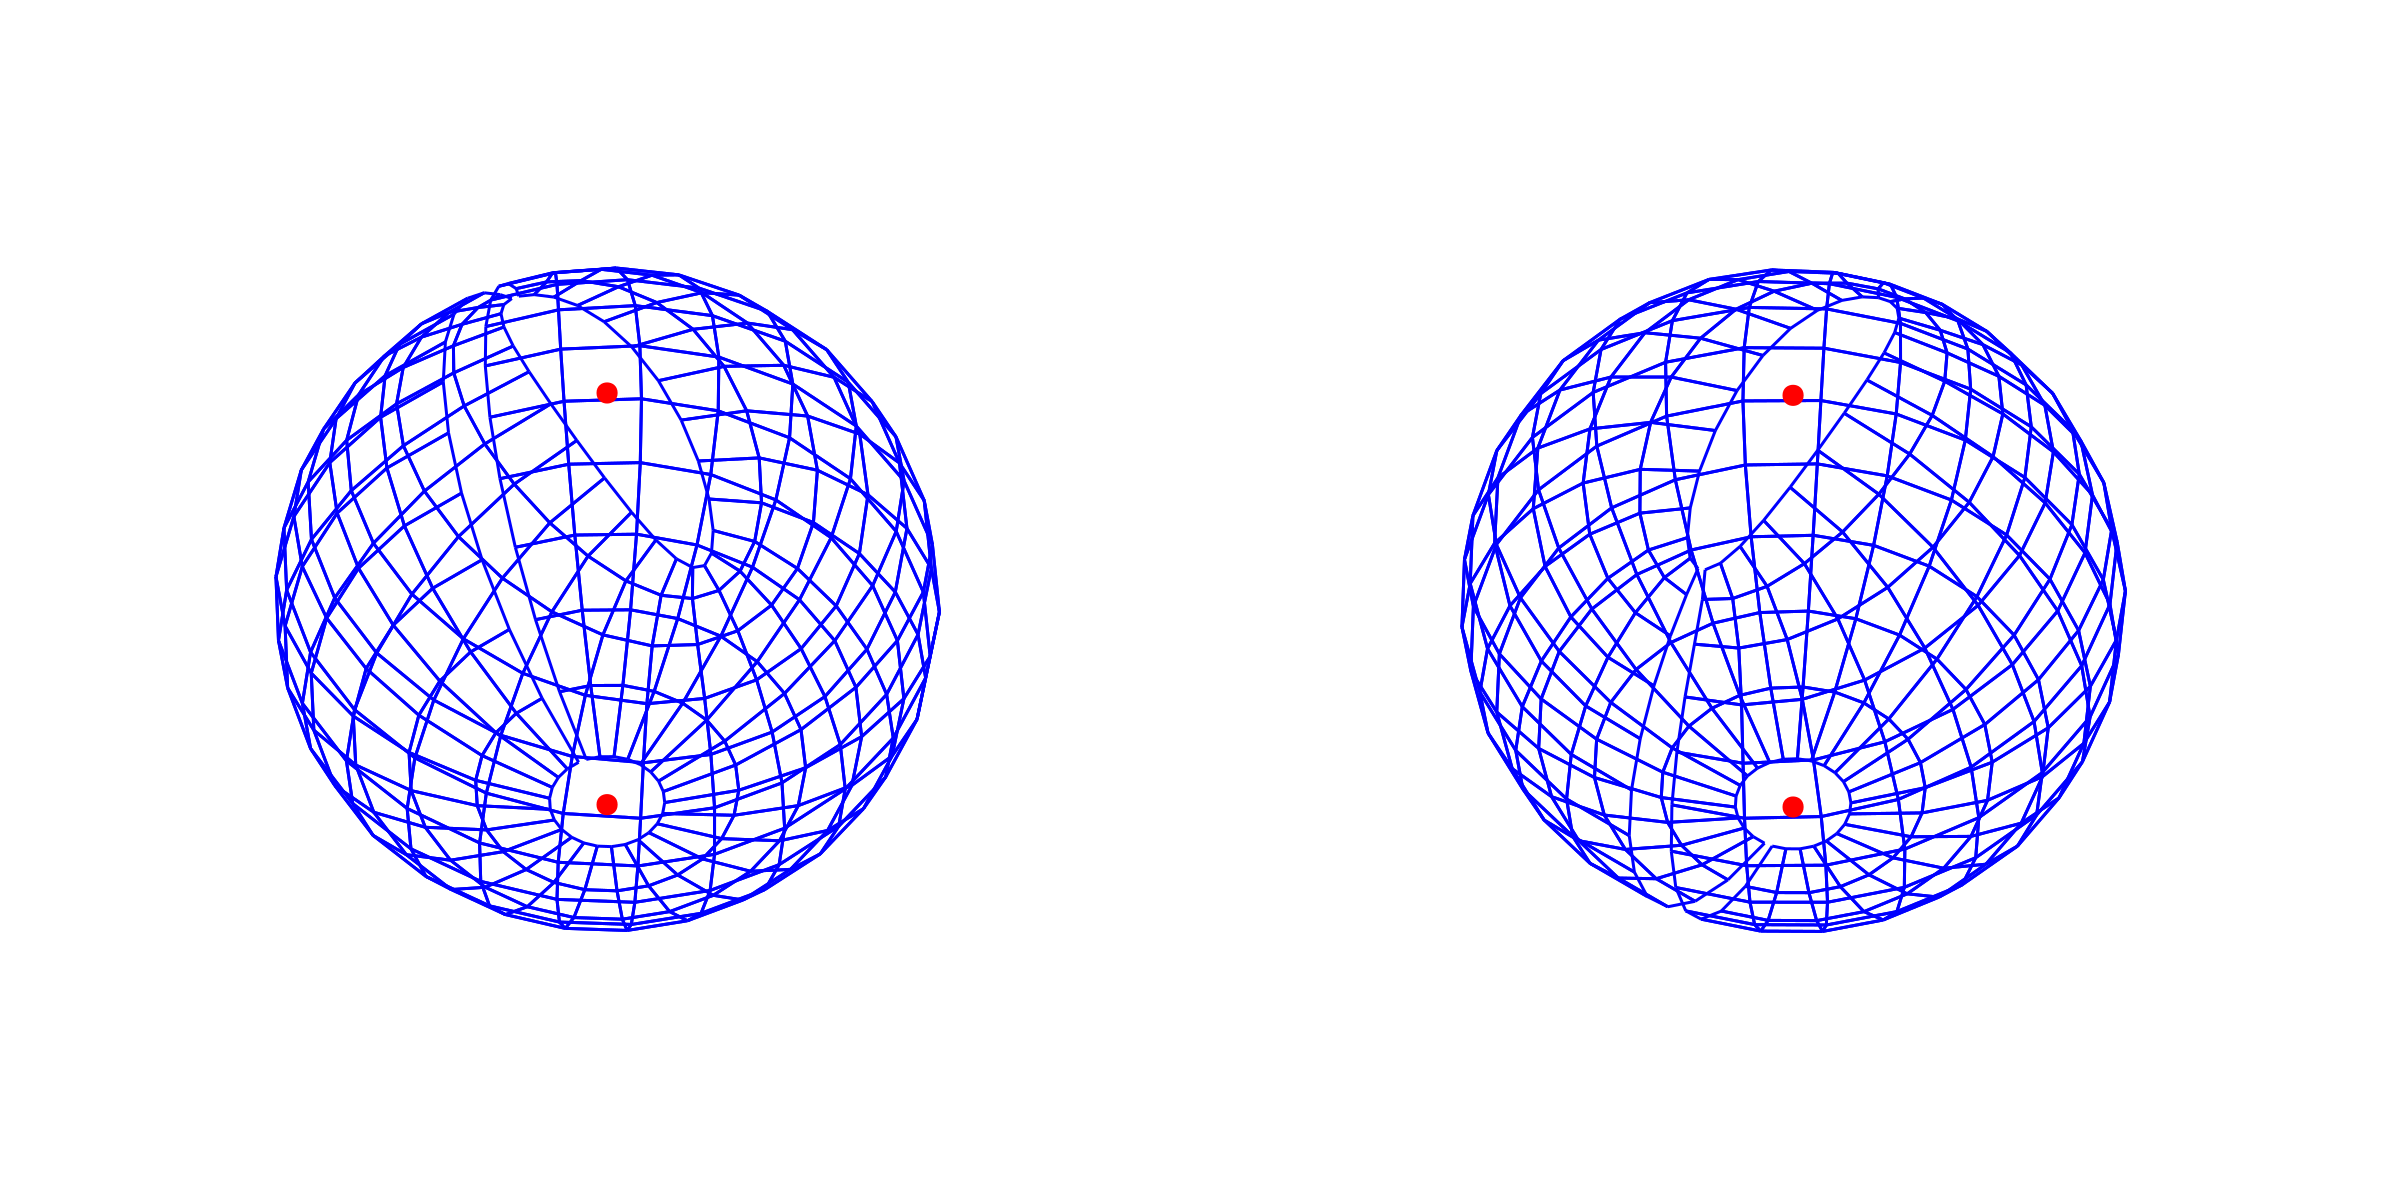

CairoMakie.Screen{IMAGE}


In [7]:
cartesian_nodes, _ = Oceananigans.Utils.get_cartesian_nodes_and_vertices(cpu_grid, Center(), Center(), Center())
xC, yC, zC = cartesian_nodes

xC = xC[1:10:end, 1:10:end, 1]
yC = yC[1:10:end, 1:10:end, 1]
zC = zC[1:10:end, 1:10:end, 1]

fig = Figure(size=(1200, 600))
axN = Axis3(fig[1, 1]; aspect=(1, 1, 1), elevation = +0.9, azimuth = 7, height=1500)
axS = Axis3(fig[1, 2]; aspect=(1, 1, 1), elevation = -0.9, azimuth = 7, height=1500)

for ax in (axN, axS)
    scale_factor = 0.99
    wireframe!(ax, xC, yC, zC, color = :blue)

    scatter!(ax, 0, 0, +1, color=:red, markersize=15)
    scatter!(ax, 0, 0, -1, color=:red, markersize=15)

    hidedecorations!(ax)
    hidespines!(ax)
end

display(fig)

## Adding a bathymetry to the grid

ClimaOcean provides a nifty utility to regrid the bathymetric data on the computational grid.
By default ClimaOcean downloads the ETOPO_2022 bathymetry at 1/60ᵒ resolution (459 MB) from the NOAA servers.
!!! NOTE: This will download the ETOPO_2022 bathymetry, so make sure that you have an internet connection

[ Info: Interpolating bathymetry of size (21600, 10800, 1) onto a TripolarGrid target grid of size (256, 128, 15)
┌ Info: Skipping extra 1 interpolation pass for bathymetry.
│ Extra interpolation passes may only be used to coarsen bathymetry
│ and require that the bathymetry is finer than the target grid in
│ both horizontal directions.
│ Grid info:
│ target grid
│ ├── minimum x-spacings 1.101e+03 m
│ └── minimum x-spacings 1.661e+03 m
│ bathymetry grid
│ ├── minimum x-spacings 2.694e-01 m
└ └── minimum x-spacings 1.853e+03 m


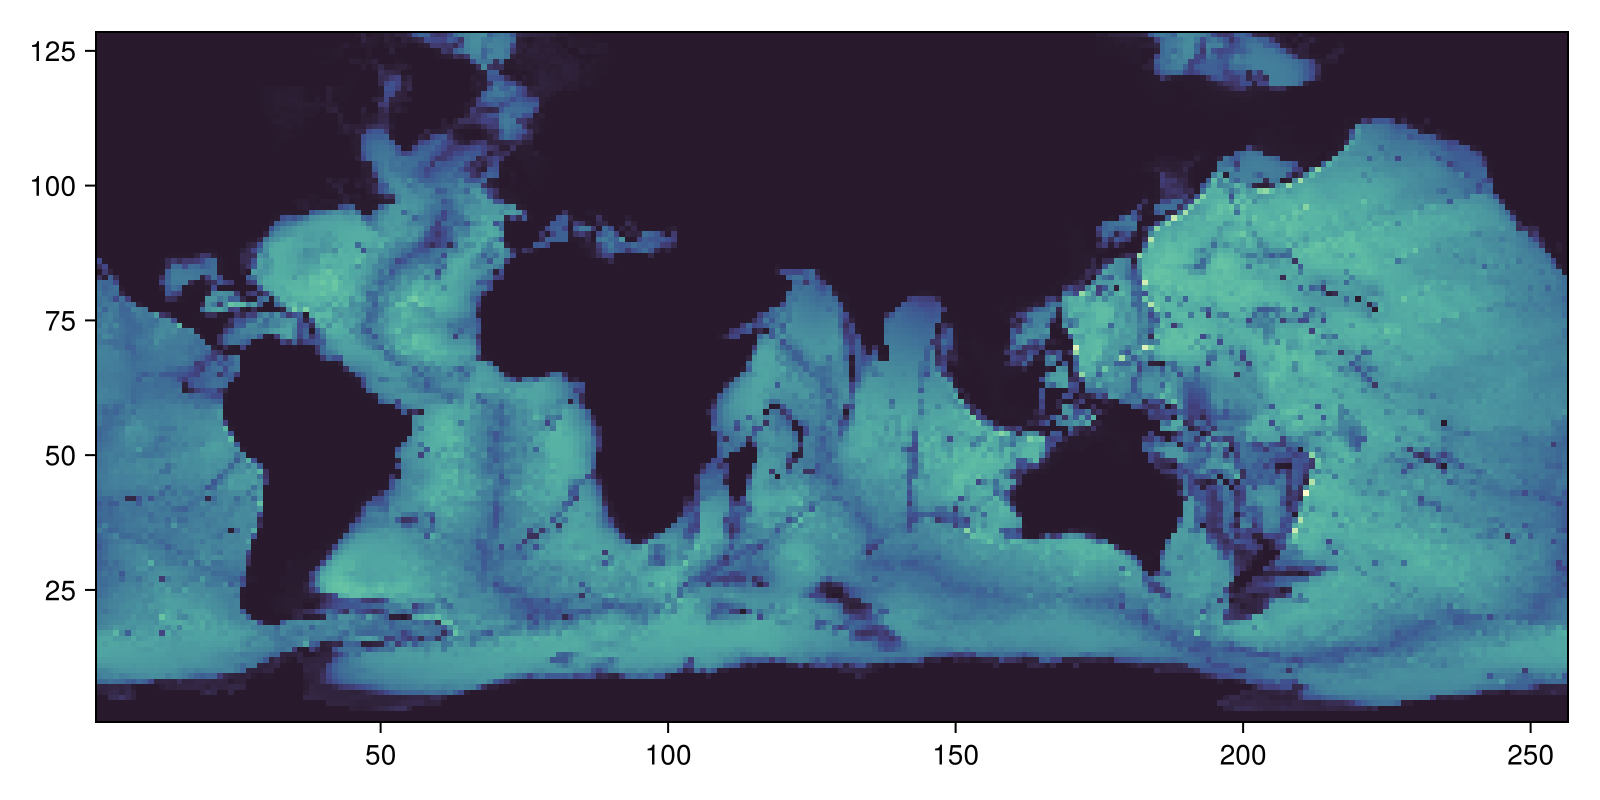

CairoMakie.Screen{IMAGE}


In [8]:
bottom_height = regrid_bathymetry(underlying_grid; minimum_depth=15, major_basins=1)
grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bottom_height); active_cells_map=true)

cpu_bottom_height = Oceananigans.on_architecture(CPU(), bottom_height)
fig = Figure(size = (800, 400))
ax  = Axis(fig[1, 1])
heatmap!(ax, interior(cpu_bottom_height, :, :, 1), colormap=:deep)
display(fig)


# Configuring an Ocean model

### Numerical details

Oceananigans allows several numerical options.
We use a WENO schemes for the advection of momentum and
a centered scheme for tracer advection, to avoid implicit diapycnal diffusion of tracers.
Stability in the momentum field is ensured by the WENO method. For the tracer field, since the centered
scheme is dispersive, we need to add some explicit diffusion to avoid numerical instabilities.

In [10]:
momentum_advection = WENOVectorInvariant(order=3)
tracer_advection   = Centered()
free_surface       = SplitExplicitFreeSurface(grid; substeps=70)

SplitExplicitFreeSurface substepping with FixedSubstepNumber(50)


### Physical parameterizations

The diffusion necessary to keep the model stable is implicitly provided by the reconstruction scheme. In ClimaOcean's simulations, typically the vertical physics is provided by the CATKE turbulence parameterization (https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2024MS004522?af=R), a state-of-the-art turbulence parameterization that computes the diffusivity from a prognostic TKE and a mixing length scale. In this case, we use a very simple convective adjustment parameterization.

Since this is a coarse model, we add some biharmonic diffusion to ensure stability of the solution 

In [11]:
numerical_mixing = HorizontalScalarBiharmonicDiffusivity(κ=1e11, ν=1e11)

vertical_mixing = ConvectiveAdjustmentVerticalDiffusivity(convective_κz = 1.0, 
                                                          convective_νz = 1e-1, 
                                                          background_κz = 1e-5, 
                                                          background_νz = 3e-4)

ConvectiveAdjustmentVerticalDiffusivity{VerticallyImplicitTimeDiscretization}(background_κz=1.0e-5 convective_κz=1.0 background_νz=0.0003 convective_νz=0.1)

### Building the ocean simulation

ClimaOcean provides a utility to build an ocean simulation with all the necessary components.
The function `ocean_simulation` returns a `Simulation` object of a `HydrostaticFreeSurfaceModel` that has
all the necessary components (BC, drag, etc) to run a global ocean simulation.

In [ ]:
ocean = ocean_simulation(grid;
                         Δt=5minutes,
                         momentum_advection,
                         tracer_advection,
                         closure=vertical_mixing,
                         free_surface)

### Initialize our Ocean

We use ECCO climatology to initialize the temperature and salinity fields.
We can use the metadata we defined earlier to set the initial conditions.
We use ECCO climatology to initialize the temperature and salinity fields.
We can use the metadata we defined earlier to set the initial conditions.
To do this we need to be able to download ECCO data. This is done automatically by `ClimaOcean`
provided that you have credentials to access the ECCO data. To do so, follow the instructions detailed in
**https://github.com/CliMA/ClimaOcean.jl/blob/main/src/DataWrangling/ECCO/README.md**

In [ ]:
using ClimaOcean.ECCO

date    = DateTime(1992, 1, 1)
dir     = "./"
dataset = ECCO4Monthly()

temperature = Metadatum(:temperature; dir, date, dataset)
salinity    = Metadatum(:salinity;    dir, date, dataset)

set!(ocean.model, T=temperature, S=salinity)

### Visualizing the initial conditions

Let's visualize the surface of our initialized ocean model

In [ ]:
fig = Figure(size = (1300, 500))
axT = Axis(fig[1, 1])
axS = Axis(fig[1, 2])

cpu_T = Oceananigans.on_architecture(CPU(), ocean.model.tracers.T)
cpu_S = Oceananigans.on_architecture(CPU(), ocean.model.tracers.S)

hmT = heatmap!(axT, interior(cpu_T, :, :, grid.Nz), colorrange=(-1, 30), colormap=:magma)
hmS = heatmap!(axS, interior(cpu_S, :, :, grid.Nz), colorrange=(28, 38), colormap=:haline)
Colorbar(fig[0, 1], hmT, vertical=false, label="Surface temperature ᵒC")
Colorbar(fig[0, 2], hmS, vertical=false, label="Surface salinity psu")

display(fig)

# Configuring a Sea ice model

The sea ice model is also written in julia (the implementation is in the `ClimaSeaIce` package), however, ClimaOcean provides an interface to build a sea-ice model using ClimaSeaIce directly on a provided grid.

In [ ]:
sea_ice = sea_ice_simulation(grid)
sea_ice.model

Once again, we initialize our sea ice model with thickness and concentration from ECCO data

In [ ]:
thickness     = Metadatum(:sea_ice_thickness;     date, dir, dataset)
concentration = Metadatum(:sea_ice_concentration; date, dir, dataset)

set!(sea_ice.model, h=thickness, ℵ=concentration)

In [ ]:
fig = Figure(size = (1300, 500))
axh = Axis(fig[1, 1])
axℵ = Axis(fig[1, 2])

cpu_h = Oceananigans.on_architecture(CPU(), sea_ice.model.ice_thickness)
cpu_ℵ = Oceananigans.on_architecture(CPU(), sea_ice.model.ice_concentration)

hmh = heatmap!(axh, interior(cpu_h, :, :, 1), colorrange=(0, 3), colormap=:magma)
hmℵ = heatmap!(axℵ, interior(cpu_ℵ, :, :, 1), colorrange=(0, 1), colormap=:haline)
Colorbar(fig[0, 1], hmh, vertical=false, label="Sea ice thickness m")
Colorbar(fig[0, 2], hmℵ, vertical=false, label="Sea ice concentration -")

display(fig)

# Adding an atmosphere

ClimaOcean is a prototype for a coupled earth system model.
It couples an atmosphere to an ocean and computes air-sea fluxes using bulk formulae.
At the moment, ClimaOcean provides a utility to download the JRA55 atmospheric reanalysis
and use it as a prescribed atmosphere.

!!! NOTE: This will download the JRA55 atmospheric reanalysis, so make sure that you have an internet connection (and enough disk space)

We use an idealized atmosphere for this tutorial to avoid downloading the JRA55 data (~15GB).

In [ ]:
atmosphere = JRA55PrescribedAtmosphere(arch; backend=JRA55NetCDFBackend(40))

In [ ]:
radiation = Radiation()

### Coupling the atmosphere to the ocean

The `OceanSeaIceModel` is an `AbstractModel` defined in ClimaOcean that couples an ocean to an atmosphere and a sea ice component.
For the moment, the sea-ice component is not implemented, so we will only couple the ocean to the atmosphere.
Instead of the sea ice model, we limit the temperature of the ocean to the freezing temperature.

In [ ]:
earth_model = OceanSeaIceModel(ocean, sea_ice; atmosphere, radiation)

### Building the simulation

We build the simulation out of the `earth_model` as we would do for any other Oceananigans model.
We start with a smallish time-step (5 minutes) and run only for 2 days to dissipate initialization shocks.

In [ ]:
earth = Simulation(earth_model; Δt=35minutes, stop_time=110days)

### Adding some diagnostics

We add a callback to save surface fields, every 2 days, while surface fluxes every 12 hours...

In [ ]:
u, v, _ = ocean.model.velocities
T = ocean.model.tracers.T
S = ocean.model.tracers.S
s = sqrt(u^2 + v^2)
η = ocean.model.free_surface.η

h = sea_ice.model.ice_thickness
ℵ = sea_ice.model.ice_concentration

earth.output_writers[:surface_tracers] = JLD2Writer(ocean.model, (; T, S, s); filename="surface_fields.jld2", 
                                                    indices=(:, :, grid.Nz-1), schedule=TimeInterval(2.5days), overwrite_existing=true)

earth.output_writers[:sea_ice_variables] = JLD2Writer(ocean.model, (; h, ℵ); filename="sea_ice_variables.jld2", 
                                                      indices=(:, :, grid.Nz), schedule=TimeInterval(2.5days), overwrite_existing=true)

earth.output_writers[:free_surface] = JLD2Writer(ocean.model, (; η); filename="free_surface.jld2", 
                                                 schedule=TimeInterval(2.5days), overwrite_existing=true)


Q  = earth.model.interfaces.net_fluxes.ocean_surface.Q
τx = earth.model.interfaces.net_fluxes.ocean_surface.u
τy = earth.model.interfaces.net_fluxes.ocean_surface.v
PE = earth.model.interfaces.net_fluxes.ocean_surface.S

earth.output_writers[:fluxes] = JLD2Writer(ocean.model, (; Q, τx, τy, PE); filename = "surface_fluxes.jld2",
                                           schedule = TimeInterval(12hours), overwrite_existing = true)

Also, we add a callback to print a message about how the simulation is going

In [ ]:
wall_time = [time_ns()]

function progress(earth)
    clock   = earth.model.clock

    maxh = maximum(h)
    maxu = maximum(abs, u)
    maxv = maximum(abs, v)
    maxT = maximum(T)
    minS = minimum(S)

    @info @sprintf("Sim time: %s, Wall time: %s, max(|u|, |v|): %.2e %.2e max(T): %.1f, min(S): %.1f, max(h): %.2f\n",
                   prettytime(clock.time), prettytime(1e-9 * (time_ns() - wall_time[1])), maxu, maxv, maxT, minS, maxh)

    wall_time[1] = time_ns()
end

earth.callbacks[:progress] = Callback(progress, IterationInterval(50))

### Running the simulation

quite simply

In [ ]:
run!(earth)

## Visualizing the results

We can visualize the results using CairoMakie. We record a video of surface variables and fluxes.
To load the data we can use Oceananigans' `FieldTimeSeries` object.

In [ ]:
using JLD2
using Oceananigans.Grids: halo_size
using CairoMakie
using Statistics: mean

file  = jldopen("free_surface.jld2")
iters = keys(file["timeseries/t"])

Hx, Hy, _ = halo_size(η.grid)
T = FieldTimeSeries("surface_fields.jld2", "T")
S = FieldTimeSeries("surface_fields.jld2", "S")
s = FieldTimeSeries("surface_fields.jld2", "s")
h = FieldTimeSeries("sea_ice_variables.jld2", "h")
ℵ = FieldTimeSeries("sea_ice_variables.jld2", "ℵ")

n  = Observable(1)
Tn = @lift(interior(T[$n], :, :, 1))
Sn = @lift(interior(S[$n], :, :, 1))
sn = @lift(interior(s[$n], :, :, 1))
hn = @lift(interior(h[$n], :, :, 1) .* interior(ℵ[$n], :, :, 1))
ηn = @lift(file["timeseries/η/" * iters[$n]][Hx+1:end-Hx, Hy+1:end-Hy, 1])

fig = Figure(size = (1000, 800))
axT = Axis(fig[1, 1:2], title="Surface temperature ᵒC")
axS = Axis(fig[1, 3:4], title="Surface salinity psu")
axs = Axis(fig[2, 1:2], title="Surface speed ms⁻¹")
axη = Axis(fig[2, 3:4], title="Sea surface height m")
axh = Axis(fig[3, 2:3], title="Sea ice effective thickness m")

hmT = heatmap!(axT, Tn, colormap=:magma,  colorrange=(-1, 30))
hmS = heatmap!(axS, Sn, colormap=:haline, colorrange=(25, 40))
hms = heatmap!(axs, sn, colormap=:deep,   colorrange=( 0, 0.8))
hmη = heatmap!(axη, ηn, colormap=:bwr,    colorrange=(-1, 1))
hmh = heatmap!(axh, hn, colormap=:greys,  colorrange=( 0, 1))

CairoMakie.record(fig, "surface_fields.gif", 1:length(T.times); framerate=5) do i
    @info "doing $i of $(length(T.times))"
    n[] = i
end

In [ ]:
display(MIME"image/png"(), read(open("surface_fields.gif")))

let's also visualize the surface fluxes that force the model!

In [ ]:
Q  = FieldTimeSeries("surface_fluxes.jld2", "Q")
τx = FieldTimeSeries("surface_fluxes.jld2", "τx")
τy = FieldTimeSeries("surface_fluxes.jld2", "τy")
PE = FieldTimeSeries("surface_fluxes.jld2", "PE")

nf  = Observable(1)
Qn  = @lift(interior(Q[$nf],  :, :, 1))
τxn = @lift(interior(τx[$nf], :, :, 1))
τyn = @lift(interior(τy[$nf], :, :, 1))
PEn = @lift(interior(PE[$nf], :, :, 1))

fig  = Figure(size = (1800, 800))
axQ  = Axis(fig[1, 1], title="Net heat flux Wm⁻²")
axPE = Axis(fig[1, 2], title="Net salt flux psu m s⁻¹")
axτx = Axis(fig[2, 1], title="Zonal wind stress Nm⁻²")
axτy = Axis(fig[2, 2], title="Meridional wind stress Nm⁻²")

hmQ  = heatmap!(axQ,  Qn,  colormap=:magma,   colorrange=(-800,  800))
hmPE = heatmap!(axPE, PEn, colormap=:haline,  colorrange=(-3e-5, 5e-5))
hmτx = heatmap!(axτx, τxn, colormap=:balance, colorrange=(-5e-4, 5e-4))
hmτy = heatmap!(axτy, τyn, colormap=:balance, colorrange=(-5e-4, 5e-4))

CairoMakie.record(fig, "surface_fluxes.gif", 1:3:length(T.times); framerate=5) do i
    @info "doing $i of $(length(Q.times))"
    nf[] = i
end

In [ ]:
display(MIME"image/png"(), read(open("surface_fluxes.gif")))